# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [1]:
!pip install datasets

In [2]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, whic

Download the dataset

In [3]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

Generating train split:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Filter row with length greater than 8.


In [4]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


Filter:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Create a tokenizer and Detokenizer

In [5]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

Remove from corpus the sentences where any unknow word appears

In [6]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [7]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [8]:
from tensorflow.keras.utils import PyDataset

class DataGenerator(PyDataset):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return (data_batch , np.array([[result[i][j] for j in range(1,len(result[i]))] for i in range(len(result))] )), np.array([[result[i][j] for j in range(len(result[i])-1)] for i in range(len(result))])

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [9]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [10]:
#split the dataset
train_generator = DataGenerator(shuffled_data[:220000])
test_generator = DataGenerator(shuffled_data[220000:])

In [11]:
(x, y), z = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)
z = detokenizer(z)

for i in range(7):
  print("shuffled: ", x[i])
  print("original shifted: ", y[i])
  print("original: ", z[i])
  print("\n")


shuffled:  <start> large their areas for cattle ranchers rainforest clear pastures become to of <end>
original shifted:  ranchers clear large areas of rainforest to become pastures for their cattle <end>
original:  <start> ranchers clear large areas of rainforest to become pastures for their cattle <end>


shuffled:  <start> stripes thorax some and the earwigs on abdomen have <end>
original shifted:  some earwigs have stripes on the thorax and abdomen <end>
original:  <start> some earwigs have stripes on the thorax and abdomen <end>


shuffled:  <start> into in magnetic such a liquid molecules can manipulation computing turn devices <end>
original shifted:  magnetic manipulation can turn molecules in a liquid into computing such devices <end>
original:  <start> magnetic manipulation can turn molecules in a liquid into computing such devices <end>


shuffled:  <start> reduced wetlands and recreation for water places healthy cleaner flooding <comma> means more <end>
original shifted:  he

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [12]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [13]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

# Solution

## Analysis of the benchmark value

Before we begin exposing the solution, we first have to set a benchmark value. We may consider as a baseline the results produced by a random shuffler: if the model is too close to a random solution we can't consider it successful enough.
In this portion of the code the entirety of the test set is processed by random shuffling the words of each sentence and computing the similarity score according to the metric provided.

Standard Deviaiton is: 0.04275765059502184
Average is: 0.15922296088781962
Benchmark value is : 0.2874959126728851


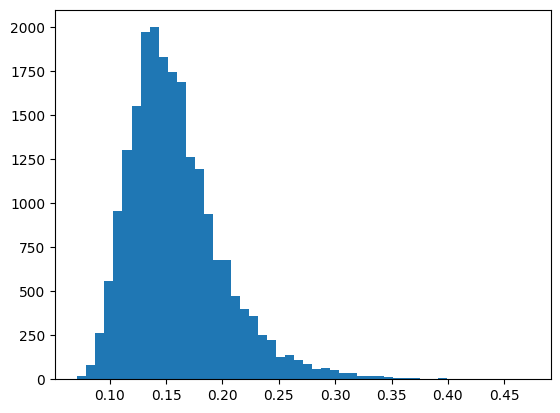

In [14]:
import matplotlib.pyplot as plt
import numpy.random as nrd
scores = []
for k in range(664):
  (x, y), z = test_generator.__getitem__(k)
  for e in range(len(x)):
    nrd.shuffle(x[e])

  for i in range(len(x)):
    scores.append( score(detokenizer(y)[i], detokenizer(x)[i]))

plt.hist(scores, bins=50)
print(f"Standard Deviaiton is: {np.std(scores)}")
print(f"Average is: {np.average(scores)}")
print(f"Benchmark value is : {np.average(scores) + 3*np.std(scores)}")

We'll consider the model far enough from the casual processing if its average scoring differs from the casual one by at least three times its standard deviation.
According to this decision our benchmark value is: 0.287.

# Model Definition

## The Architecture

To implement the solution the chosen architecture is the Transformer, one of the most famous models used for developing Sequence to Sequence operations. 
The Transformer architecture is divided into three main components:
* Encoder
* Decoder
* Feed-forward

The first two being the most important as they encapsulate entirely the mechanism of Attention, which is crucial to the effectiveness of the architecture. We will examine each layer and its internal structure in the following paragraphs.

In [15]:
LEN_VOC = 10000
LEN_SENT = 28
LEN_EMBED = 64
LEN_TARGET_SENT= 27
HEADS = 6
LEN_FF = 256
DROPOUT=0.01

In the previous cell we find some structural constants which will be used during the development of the whole solution.
We have:
* Length of the vocabulary
* Length of the longest sentence we want to reorder
* Length of the inner embedding inside the trasnformer
* Length of the longest target sentence
* Number of Heads in the Self Attention Layers
* Size of the internal Feed-forward layers
* Dropout rate

## Encoder

The encoder is the first main component of the Transformer Architecture, its role is the conversion of the tokenized input into an inner representation, to do so the inputs have to cross many inner layers. Inside the Encoder we find the following layers:
* Token Embedding Layer, its task is to create an inner representation of the tokens inside the space with dimension LEN_EMBED
* Positional Embedding Layer, its task is to provide the encoding with information about position by sampling function such as sine and cosine
* 5 X Encoder Layer, enact the self attention mechanism inside the encoder, according to the most common architecture multiple of them were stacked to provide a better internal representation. Their structure will be analysed in the following cell.

### Encoder Layer

This is the main internal layer inside the Encoder Block and implments the self attention mechanism with multiple heads (6) in two separate layers.
Inside this complex layer we have different sublayers:
* First Multi-head Attention layer, which applies the self attention mechanism to the inputs of the layer
* First Normalization layer, which is introduced to contrast the phenomenon of exploding gradients using residual connections
* Second Multi-head Attention layer, which applies the self attention mechanisms to the output of the normalization layer
* Second Normalization layer, has the same function as the first one
* Feed Forward Layer, it's a dense layer which helps in capturing eventual non linear relationships inside the model
* Third Normalization Layer, has the same function as the other two
* Dropout layer, introduced to prevent overfitting, it deactivates some units from previous layers to create different configurations each time.

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
     def __init__(self, num_heads, ff_size, embed_size):
        super().__init__() 
        
        #First self attention layer + normalization layer
        self.multihead1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=LEN_EMBED)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        #Second self attention layer + normalization layer
        self.multihead2= tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=LEN_EMBED)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        #Feed-forward dense layer + normalization layer
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(ff_size, activation="leaky_relu"), tf.keras.layers.Dense(LEN_EMBED),])
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        #Dropout layer
        self.dropout = tf.keras.layers.Dropout(rate=DROPOUT)


     def call(self, inputs):
        

        #Self Attention Section 1
        attn_output_1 = self.multihead1(inputs, inputs)
        out_1 = self.layernorm1(inputs + attn_output_1)
        
        
        #Self Attention Section 2
        attn_output_2 = self.multihead2(out_1, out_1)
        out_2 = self.layernorm2(out_1 + attn_output_2)

        #Feed Forward Section
        ffn_output = self.ffn(out_2)
        ffn_output = self.dropout(ffn_output)
        out_3 = self.layernorm3(out_2 + ffn_output)

        return out_3

### Complete Encoder

Here the complete encoder block is assembled, it extends the Layer class and reimplements two methods:
* __init__ method to provide the new attributes (i.e. the sub-layers)
* __call__ method which executes the internal steps of the encoder and successive processing of the inputs.

In [17]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_heads, ff_size, embed_size):
    super().__init__()
    
    #Definition of the Token Embedding Layer
    self.token_embedding = tf.keras.layers.Embedding(input_dim=LEN_VOC, output_dim=LEN_EMBED, mask_zero=True)
    
    #Definition of the Positional Embeding Layer
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=LEN_SENT, output_dim=LEN_EMBED)
    
    #Definition of the 5 internal EncoderLayer
    self.encoder_1 = EncoderLayer(num_heads, ff_size, embed_size)
    self.encoder_2 = EncoderLayer(num_heads, ff_size, embed_size)
    self.encoder_3 = EncoderLayer(num_heads, ff_size, embed_size)
    self.encoder_4 = EncoderLayer(num_heads, ff_size, embed_size)
    self.encoder_5 = EncoderLayer(num_heads, ff_size, embed_size)
    


  def call(self, inputs):
        
        #Computing the token and positional embedding for the inputs
        x=inputs
        maxlen = tf.shape(x)[-1]
        positions = tf.keras.ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_embedding(positions)
        x = self.token_embedding(x)
        out_1 = x + positions 
        
        #Processing encoded inputs through the internal encoder layers
        out_2 = self.encoder_1(out_1)
        out_3 = self.encoder_2(out_2)
        out_4 = self.encoder_3(out_3)
        out_5 = self.encoder_4(out_4)
        out_6 = self.encoder_5(out_5)
        return out_6

## Decoder


The decoder is the second component of the Transformer Architecture, its role is different during training and inference:
* When training, the decoder receives as input the correct sequence with the objective of learning how to associate the inner representation produced by the encoder to the corect sequence.
* During inference, the decoder will receive the starting token and iteratively produce the sequence of tokens that will constitute the complete, reordered sequence.

The internal structure of the decoder is very similar to the encoder with the introduction of one more layer inside the decoder layer:
* Token Embedding Layer, its task is to create an inner representation of the input tokens inside the space with dimension LEN_EMBED
* Positional Embedding Layer, its task is to provide the encoding with information about position by sampling function such as sine and cosine
* 5 X Decoder Layer, enacts the self attention mechanism inside the encoder, according to the most common architecture multiple of them were used to provide a better internal representation. Their structure will be analysed in the following cell.

### Decoder Layer

This is the main internal layer inside the Decoder Block and implements the self attention mechanism with multiple heads (6) in three separate layers. Its structure is very reminiscent of the Encoder Layer, we have different sublayers:

* First Multi-head Attention layer, it's the main difference from the encoder layer and uses a causal mask to prevent the model from looking at future tokens when predicting the next one, thus implementing the Causal Attention mechanism.
* First Normalization layer, which is introduced to contrast the phenomenon of exploding gradients using residual connections
* Second Multi-head Attention layer, which applies the self attention mechanism to the inputs of the layer
* Second Normalization layer, serves the same function as the first
* Third Multi-head Attention layer, which applies the self attention mechanisms to the output of the normalization layer
* Third Normalization layer, has the same function as the first two
* Feed Forward Layer, it's a dense layer which helps in capturing eventual non linear relationships inside the model
* Third Normalization Layer, has the same function as the other three
* Dropout layer, introduced to prevent overfitting, it deactivates some units from previous layers to create different configurations each time.

In [18]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_size, embed_size):
        super().__init__() 
        
        #Casual attention layer + normalization layer
        self.multihead_mask = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=LEN_EMBED)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        #First self attention layer + normalization layer
        self.multihead1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=LEN_EMBED)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        #Second self attention layer + normalization layer
        self.multihead2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=LEN_EMBED)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        #Feed-forward dense layer + normalization layer
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(ff_size, activation="leaky_relu"), tf.keras.layers.Dense(LEN_EMBED),])
        self.layernorm4 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
        #Dropout layer
        self.dropout = tf.keras.layers.Dropout(rate=DROPOUT)

     
   
    
    
    def call(self, encoder_out, decoder_inp_embed):
        
 
        causal_output = self.multihead_mask(decoder_inp_embed, decoder_inp_embed, use_causal_mask=True)
        out_1 = self.layernorm1(decoder_inp_embed + causal_output)

        #Self Attention Section 1
        attn_output_1 = self.multihead1(out_1, encoder_out)
        out_2= self.layernorm2(out_1 + attn_output_1)

        #Self Attention Section 2
        attn_output_2 = self.multihead2(out_2, encoder_out)
        out_3 = self.layernorm3(out_2 + attn_output_2)

        #Feed Forward Section
        ffn_output = self.ffn(out_3)
        ffn_output = self.dropout(ffn_output)
        out_4 = self.layernorm4(out_3 + ffn_output)

        return out_4

### Complete Decoder

Here the complete decoder block is assembled, it extends the Layer class and reimplements two methods:
* __init__ method to provide the new attributes (i.e. the sub-layers)
* __call__ method which executes the internal steps of the decoder and successive processing of the inputs.

Inside the Decoder is also integrated the final Feed-Forward layer which will output the probabilites for each word predicted inside the dictionary.

In [19]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_heads, ff_size,embed_size):
    super().__init__()
    
    #Definition of the Token Embedding Layer
    self.token_embedding = tf.keras.layers.Embedding(input_dim=LEN_VOC, output_dim=LEN_EMBED, mask_zero=True)
    
    #Definition of the Positional Embeding Layer
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=LEN_TARGET_SENT, output_dim=LEN_EMBED)
    
    #Definition of the 5 internal EncoderLayer
    self.decoder_1 = DecoderLayer(num_heads, ff_size, embed_size)
    self.decoder_2 = DecoderLayer(num_heads, ff_size, embed_size)
    self.decoder_3 = DecoderLayer(num_heads, ff_size, embed_size)
    self.decoder_4 = DecoderLayer(num_heads, ff_size, embed_size)
    self.decoder_5 = DecoderLayer(num_heads, ff_size, embed_size)
    
    #Definition of the output dense layer
    self.outlayer = tf.keras.layers.Dense(LEN_VOC, activation='softmax')


  def call(self, encoder_out, decoder_inp):
            
        #Computing the token and positional embedding for the inputs
        x=decoder_inp
        maxlen = tf.shape(x)[-1]
        positions = tf.keras.ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_embedding(positions)
        x = self.token_embedding(x)
        out_1 = x + positions
        
        #Processing encoded inputs through the internal decoder layers
        out_2 = self.decoder_1(encoder_out, out_1)
        out_3 = self.decoder_2(encoder_out, out_2)
        out_4 = self.decoder_3(encoder_out, out_3)
        out_5 = self.decoder_4(encoder_out, out_4)
        out_6 = self.decoder_5(encoder_out, out_5)
        

        #Returning the output through the dense layer
        return self.outlayer(out_6)

## Transformer

The Trasformer class extends the Model class and joins Encoder and Decoder together, it redefines three methods:
* __init__ method to set the Encoder and Decoder attributes
* __call__ to apply the two inner complex layer to the inputs
* __predict__ used during the testing phase to orchestrate the production of the output sequence token by token starting from the BOS token.

In [23]:
class Transformer(tf.keras.Model):
    def __init__(self, num_heads, ff_size, embed_size):
            super().__init__()
            self.encoder = Encoder(num_heads, ff_size, embed_size)
    
            self.decoder = Decoder(num_heads, ff_size, embed_size)

            
            

    
    def generate_initial_decoder_input(self, batch_size):
        start_token = tf.constant([3], dtype=tf.int32)  # Assuming 3 is the start token
        return tf.tile(tf.expand_dims(start_token, 0), [batch_size, 1])
    
    def call(self, encoder_inp, training):
       
        encoder_input, decoder_inp = encoder_inp
        encoder_out = self.encoder(encoder_input)
        
        decoder_out = self.decoder(encoder_out, decoder_inp)
        
        return decoder_out
    
        
    def predict(self, x, *args, **kwargs):
        encoder_input, decoder_inputs = x

        max_length = 28

        batch_size = encoder_input.shape[0]
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)

        start = np.array(tokenizer.word_index[''], ndmin=1)
        output_array = output_array.write(0, tf.tile(start, [batch_size]))

        for i in tf.range(max_length-1):
            output = tf.transpose(output_array.stack())
            predictions = self([encoder_input, output], training=False)

            # Select the last token from the seq_len dimension.
            predictions = predictions[:, -1:, :]  # Shape (batch_size, 1, vocab_size).

            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the predicted_id to the output which is given to the
            # decoder as its input.
            output_array = output_array.write(i+1, predicted_id[:, 0])
        
            end_mask = tf.reduce_any(tf.equal(predicted_id, tokenizer.word_index['']), axis=-1)
            if tf.reduce_all(end_mask):
                  break

        output = tf.transpose(output_array.stack())
        self([encoder_input, output[:,:-1]], training=False)
      
        return output      

## Complete model

Here the entrire model is fully defined by providing the two input layers:
* input which will feed directly into the encoder
* target which will feed directly into the decoder during the training

A summary of the model is produced to highlight the number of parameters before training.

In [24]:
training=False
inputs = tf.keras.Input(shape=(LEN_SENT,))
target = tf.keras.Input(shape=(LEN_TARGET_SENT,))
outputs = Transformer(HEADS, LEN_FF, LEN_EMBED)(encoder_inp=[inputs, target], training=training)
model = tf.keras.Model(inputs=[inputs, target], outputs=outputs)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer         │ (None, 27, 10000) │  4,756,880 │ input_layer_4[0]… │
│ (Transformer)       │                   │            │ input_layer_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,756,880 (18.15 MB)

 Trainable params: 4,756,880 (18.15 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In this part the model is trained using a split of the dataset of 220000 samples, 10000 of which were used for validation.
The choice for the optimizer is AdamW with a starting learning step of 0.00005, which is known as one of the best optimizer for transformer training.

The training goes on for a total of 10 epochs, the accuracy is evaluated throughout the whole process.

Another summary is printed to highlight the number of parameters after the training has concluded.

In [25]:
train_generator = DataGenerator(original_data[:210000], batch_size=32)
validation_generator = DataGenerator(original_data[210000:220000], batch_size=32)
test_generator = DataGenerator(original_data[220000:], batch_size=32)

opt = tf.keras.optimizers.AdamW(0.00005, gradient_accumulation_steps=4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, batch_size=32, epochs=10, validation_data=validation_generator)

model.summary()

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718177063.822682     127 service.cc:145] XLA service 0x7b3e4c0566b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718177063.822730     127 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1718177063.822733     127 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1718177066.056806     127 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1718177091.305773     183

6561/6562 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4710 - loss: 6.3223

W0000 00:00:1718177359.097242     127 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


6562/6562 ━━━━━━━━━━━━━━━━━━━━ 364s 36ms/step - accuracy: 0.4710 - loss: 6.3218 - val_accuracy: 0.6523 - val_loss: 2.8104
Epoch 2/10
6562/6562 ━━━━━━━━━━━━━━━━━━━━ 230s 35ms/step - accuracy: 0.6784 - loss: 2.4616 - val_accuracy: 0.7535 - val_loss: 1.7738
Epoch 3/10
6562/6562 ━━━━━━━━━━━━━━━━━━━━ 234s 36ms/step - accuracy: 0.7770 - loss: 1.5832 - val_accuracy: 0.8318 - val_loss: 1.2593
Epoch 4/10
6562/6562 ━━━━━━━━━━━━━━━━━━━━ 230s 35ms/step - accuracy: 0.8595 - loss: 1.0920 - val_accuracy: 0.8908 - val_loss: 0.9022
Epoch 5/10
6562/6562 ━━━━━━━━━━━━━━━━━━━━ 228s 35ms/step - accuracy: 0.9121 - loss: 0.7568 - val_accuracy: 0.9275 - val_loss: 0.6551
Epoch 6/10
6562/6562 ━━━━━━━━━━━━━━━━━━━━ 228s 35ms/step - accuracy: 0.9444 - loss: 0.5291 - val_accuracy: 0.9525 - val_loss: 0.4774
Epoch 7/10
6562/6562 ━━━━━━━━━━━━━━━━━━━━ 228s 35ms/step - accuracy: 0.9658 - loss: 0.3702 - val_accuracy: 0.9705 - val_loss: 0.3452
Epoch 8/10
6562/6562 ━━━━━━━━━━━━━━━━━━━━ 231s 35ms/step - accuracy: 0.9809 - lo

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer         │ (None, 27, 10000) │  4,756,880 │ input_layer_4[0]… │
│ (Transformer)       │                   │            │ input_layer_5[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,027,522 (72.58 MB)

 Trainable params: 4,756,880 (18.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,270,642 (54.44 MB)

## Test the Model

In this last section the model is tested iterating over 21000 test samples, appending the results inside a list and then computing the average scoring. From what we can see, the average is way over the benchmark threshold, thus proving the success of the model.

In [26]:
#Testing the model
scores_pred=[]
EXAMPLE = 15
#Cycling through all samples
for k in range(664):
  x, y = test_generator.__getitem__(k)
  predictions = model.predict(x, batch_size=32, verbose=False)
  best = [[np.argmax(predictions[u][:][r]) for r in range(len(predictions[u]))] for u in range(len(predictions))]
  for i in range(len(x)):
    #Appending scores of the predictions
    scores_pred.append(score(detokenizer(y)[i], detokenizer(best)[i]))

print(f"Standard Deviaiton is: {np.std(scores_pred)}")
print(f"Average is: {np.average(scores_pred)}")

I0000 00:00:1718179545.285928    5735 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_147', 108 bytes spill stores, 108 bytes spill loads

I0000 00:00:1718179547.405883    5732 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_149', 108 bytes spill stores, 108 bytes spill loads



Standard Deviaiton is: 0.10241333716390603
Average is: 0.963303125945355


In [29]:
#Saving weights
model.save_weights('Sentence_Reordering_weights.weights.h5')

Model weights are saved.